This is a DQN for the Lunar lander problem.

# How we might make this work for codons
      
For codons:
Input nodes: n states (len of protein)
one-hot encode all 64 AAs into an integer number
actions that can be chosen:
- say k codons have been chosen. then there are n-k codons left to choose.
- given the k codons chosen, what is the best next one to choose?
so all the actions possible: there are ~ (n-k)*c choices where c is av_codons per aa.
max possible actions will be n * 6 since 6 codons max per aa.
- so e.g. 15 * 6 = 90 possible actions.
- e.g. choose TTC @ position 12

So 90 possible actions and then maybe the network just deals with combinations of states on/off.

Questions: 
- how to encode the states? One-hot encode the codons as integers an pass to model? Not sure.
- this example doesn't have a target network. how would i implement?


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


episode 0 score -94.90 average score -94.90 epsilon 1.00
episode 1 score -97.40 average score -96.15 epsilon 0.95
episode 2 score -359.78 average score -184.03 epsilon 0.89
episode 3 score -62.00 average score -153.52 epsilon 0.86
episode 4 score -105.47 average score -143.91 epsilon 0.82
episode 5 score 5.53 average score -119.00 epsilon 0.75
episode 6 score -83.82 average score -113.98 epsilon 0.68
episode 7 score -35.77 average score -104.20 epsilon 0.58
episode 8 score -53.01 average score -98.51 epsilon 0.52
episode 9 score -234.45 average score -112.11 epsilon 0.42
episode 10 score -244.27 average score -124.12 epsilon 0.34
episode 11 score -251.00 average score -134.69 epsilon 0.24
episode 12 score -6.68 average score -124.85 epsilon 0.10
episode 13 score -189.73 average score -129.48 epsilon 0.01
episode 14 score -79.84 average score -126.17 epsilon 0.01
episode 15 score -191.42 average score -130.25 epsilon 0.01
episode 16 score -226.16 average score -135.89 epsilon 0.01
episo

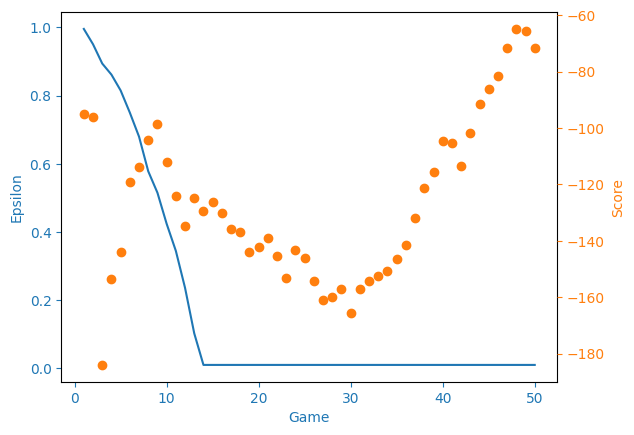

In [8]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F # to use ReLu for DNN
import torch.optim as optim # for Adam optimiser
import numpy as np
import gym
import matplotlib.pyplot as plt

# https://www.youtube.com/watch?v=wc-FxNENg9U
# OHE:
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/

# 8-vector observation only -> no convolutional layers required


# will write it in 2 classes:
    # 1. Deep q network (DQN)
    # 2. Agent
    # reason for 2 classes:
    # agent is not a DQN, rather an agent HAS a DQN
    # agent has a MEMORY - a way of choosing actions as well as
    # learning
    # the DQN - state as input, outputs agent's estimate of 
    # action-values for each given state.

# PyTorch: every class EXTENDS functionality of base NN layers
# this gives us access to e.g. backpropagation function.
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super().__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        # first layer of NN:
        # the star in *self.input_dims  will UNPACK
        # an input list of 8 (8 elements of observation vector)
        # (allows you to make this more extensible)
        # NB: fc indicates Fully Connected layer
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        
        # second NN layer:
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        
        # DNN output:
        # A DQN is an estimate of actions given a set of states.
        # if agent performs given action what is its expected future reward
        # if it follows that policy?
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        
        # Use a MSE loss function because Qlearning is kind of like a linear
        # regression: we're trying to fit DNN to target value
        self.loss = nn.MSELoss()
        
        # this will be a simple representation of DQN: 
        # won't use Replay net and target N, we will only use 
        # replay network. in this case, target network not required.
        
        # takes advantage of a GPU if available, else cpu:
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
        
        # move model to that device.
        self.to(self.device)
        
        # don't have to handle backpropagation (included in parent class)
        # but DO have to handle forward propagation:
        
    # this ISN'T pre-included, because the user has to define their
    # activation functions.
    def forward(self, state):
        x = F.relu(self.fc1(state)) # pass a state into first fc layer
        # then pass the output to the 2nd fc layer
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
            
        # don't want to activate the action (i.e. don't want to pass to
        # ReLu function), since want agent's RAW estimation.
        return(actions)

# The main functionality will live in the agent class.
# derives from no other class
# gamma is discount HP which determines weighting of future rewards
# epsilon is explore / exploit
# lr is learning rate to pass to DQN
# 

# could i One-Hot-Encode the codon inputs?
# state is number of positions
# in each position read if codon present
# then do -> x
# available actions would be choose one codon anywhere
# would be e.g. 15 * ~3 =~45 possible actions for a 15 seq

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        # list comprehension telling us the integer representation of
        # available actions.
        # makes easier to select action in epsilon_greedy function
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        # dims of fc layers is not mega critical
        # it matters, but generally the model will work for a wide
        # range of neurons in the fc layers.
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, 
                                   fc1_dims=256, fc2_dims=256)
        
        # in addition to NN, also need a way to store MEMORY
        # many people use a deque ("DECK" or "D.Q.")
        # a DQ is a Linked List - a dynamic memory structure
        # pop off one end and input to other.
        # TODO: read up on linked lists.
        
        # this guy prefers to use a regular array though:
        # the data type is very important here.
        # Pytorch enforces type checking -> this saves your bacon later on
        # since you lose stuff when you go from one level of precision to another
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        
        # define a memory to keep track of the new states an agent encounters:
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),dtype=np.float32)
        
        # ^ this is required, since the agent want to know:
        # (for the temporal difference update rule)
        # what is 
        # - the value of the current state
        # - the value of the next state
        # - the reward it received
        # - the action it took
        # so you need to pass in the memory of the state which resulted from
        # its actions.
        
        # recall: DQN is a MODEL-FREE, BOOTSTRAPPED, OFF-POLICY learning method
        # that means:
        # Model-free: don't know anything about environment or how game works,
        #             will learn by playing
        # Bootstrapped: construct estimates of action-value functions - i.e. 
        #               the value of each action given you're in some state:
        #               using 1 estimate to make another -> pulling self up by bootstraps
        # Off-policy: the policy we want to follow is optimised greedy, BUT we use
        #             greedy + random (i.e. a different policy) to update the main policy
        
        # DQN doesn't really work for continuous action spaces
        # therefore now we use dtype = int32
        self.action_memory = np.zeros((self.mem_size),dtype=np.int32)
        
        # rewards could be floating point, so dtype=float32
        self.reward_memory = np.zeros((self.mem_size),dtype=np.float32)
        
        # need to say when game if finished (end of epoch)
        # the value of the terminal state is always zero.
        # the reason: if you encounter terminal state, game is done
        # if you encounter terminal state, end episode
        # the future value of terminal state is identically zero
        # need to tell agent this when it updates action-value function q
        self.terminal_memory = np.zeros((self.mem_size),dtype=np.bool)
        
    # interface function to store transition in agent's memory
    def store_transition(self, state, action, reward, state_, done):
        # state_ is the new state, done is a flag to say done
        
        # what is the position of the first unnoccupied memory?
        index = self.mem_cntr % self.mem_size
        # modulus: this will wrap around -> rewrite agent's earliest mem
        # with new memories (since memory is finite)
        
        # now that we know WHERE to store, let's store it
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        # increment memory counter
        self.mem_cntr += 1
        
    # agent needs some function to choose an action
    # that is based on present state (observation) of environment
    def choose_action(self, observation):
        if np.random.random() > self. epsilon:
            # turn observation into PyTorch tensor
            # and send it to our device
            # the whole network lives on the device, so we need to send
            # variables we want to compute on to the device
            # square brackets needed due to way DNN is set up:
            state = T.tensor([observation]).to(self.Q_eval.device)
            # pass state to DQN:
            actions = self.Q_eval.forward(state)
            # argmax to get integer corresponding to maximal action for that state
            action = T.argmax(actions).item()
            # ^ the .item() dereferences from the tensor
        else:
            action = np.random.choice(self.action_space)
        
        return(action)

    # Now we have a way to choose actions, need to set up how agent will
    # learn from its experiences:
    
    def learn(self):
        # dilemma: memory currently filled with zeros
        # can't learn from that - would be stupid.
        # either let agent be random and fill up mem, then start learning
        
        # OR, we can (and we will) start learning once the memory has filled
        # up to the batch size:
        
        if self.mem_cntr < self.batch_size:
            # don't bother learning
            return
        
        # particular to PyTorch: need to zero gradient on our optimizer:
        # (for when we start learning)
        self.Q_eval.optimizer.zero_grad()
        
        # need to calculate position of maximum memory
        # since want to select a subset of memories.
        # but only wish to select up to the last filled memory
        max_mem = min(self.mem_cntr, self.mem_size)
        
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        # ^ replace = False because don't want to use the same memories more
        # than once
        
        # for proper array slicing:
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        # convert agent's memory to PyTorch tensor and send to device:
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        action_batch = self.action_memory[batch]
        
        # now need to perform feed-forwards through NN to get relevant 
        # parameters for our loss function
        # idea is to move agent's estimate of the current state towards the
        # maximal value of the next state. -> tilt towards selecting maximal
        # actions.
        
        # the slicing is to dereference
        # reason is we want values of actions we actually took
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        # IF we were using a target network, we would use it here in the above
        # line. (that's more advanced though - won't bother here.)
        q_next[terminal_batch] = 0.0
        
        # target value is what we want to update estimates towards:
        # dim=1 is the action dimension
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        # ^ we slice zero as T.max returns value and the index as a tuple
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        
        # then do backpropagation:
        loss.backward()
        
        # step optimizer:
        self.Q_eval.optimizer.step()
        
        # next need to handle the epsilon decrement.
        # each time we learn, decrement epsilon:
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
            else self.eps_min
        
        # That's it! 
        # this is the simplest implementation of the learning function
        # NB: read up to here from top to understand.

        
# Copied from his github repo:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
    
  #  print(x)
  #  print(epsilons)
    #x = x[:len(epsilons)]
    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)
    
   # plt.legend()
    plt.savefig(filename)




if __name__ == "__main__":
    import gym
    env = gym.make("LunarLander-v2")
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4,
                  eps_end = 0.01, input_dims=[8], lr=0.003)
    # to plot scores & epsilon decay over time.
    scores, eps_history = [], []
    n_games = 50
    
    # at the top of each game reset score, env, done flag
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done: # while codons chosen < len(protein)
            action = agent.choose_action(observation) # based on current state of env.
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            # set current state to new state.
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)
        avg_score = np.mean(scores[-100:])
                
        print("episode", i, "score %.2f" % score, 
              "average score %.2f" % avg_score,
              "epsilon %.2f" % agent.epsilon)
        
    x = [i+1 for i in range(n_games)] # just the x-axis
    filename = "lunar_lander_2023.png"
    plotLearning(x, scores, eps_history, filename)

        
        # clone repo for this.
        
        # a target network would help with model stability over time.






